In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
GOOGLE_COLAB = True

In [0]:
%reload_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import sys
if GOOGLE_COLAB:
    sys.path.append('drive/My Drive/yelp_sentiment_analysis')
else:
    sys.path.append('../')

from yelpsent import data
from yelpsent import features
from yelpsent import metrics
from yelpsent import visualization
from yelpsent import models

In [0]:
import importlib
def reload():
  importlib.reload(data)
  importlib.reload(features)
  importlib.reload(metrics)
  importlib.reload(visualization)
  importlib.reload(models)

# Load Dataset

In [0]:
if GOOGLE_COLAB:
    data_train, data_test = data.load_dataset("drive/My Drive/yelp_sentiment_analysis/data/yelp_train_balanced.json",
                                              "drive/My Drive/yelp_sentiment_analysis/data/yelp_test.json")
else:
    data_train, data_test = data.load_dataset("../data/yelp_train.json",
                                              "../data/yelp_test.json")

In [0]:
X_train = data_train['review'].tolist()
y_train = data_train['sentiment'].tolist()

In [0]:
X_test = data_test['review'].tolist()
y_test = data_test['sentiment'].tolist()

# Load DTMs

In [0]:
with open('drive/My Drive/yelp_sentiment_analysis/pickles/vectorizer.pickle', 'rb') as f:
    vectorizer = pickle.load(f)

with open('drive/My Drive/yelp_sentiment_analysis/pickles/X_train_dtm.pickle', 'rb') as f:
    X_train_dtm = pickle.load(f)

with open('drive/My Drive/yelp_sentiment_analysis/pickles/X_test_dtm.pickle', 'rb') as f:
    X_test_dtm = pickle.load(f)

# XGBoost Classifier

In [0]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [0]:
# Grid-search
params = {'max_depth' : [3, 5, 7]}

gscv = GridSearchCV(XGBClassifier(num_classes = 3,
                                  objective = 'multi:softmax',
                                  eval_metric = "mlogloss",
                                  n_estimators = 500),
                    params,
                    scoring='f1_macro',
                    cv=3,
                    verbose=1,
                    n_jobs=-1)

In [17]:
gscv.fit(X_train_dtm, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 244.6min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, eval_metric='mlogloss',
                                     gamma=0, learning_rate=0.1,
                                     max_delta_step=0, max_depth=3,
                                     min_child_weight=1, missing=None,
                                     n_estimators=500, n_jobs=1, nthread=None,
                                     num_classes=3, objective='multi:softmax',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1, param_grid={'max_depth': [3, 5, 7]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score

In [18]:
print(gscv.best_params_)

{'max_depth': 7}


In [0]:
# Final model
model = XGBClassifier(num_classes = 3,
                      objective = 'multi:softmax',
                      eval_metric = 'mlogloss',
                      max_depth=7,
                      n_estimators = 800,
                      seed = 647,
                      n_jobs = -1)

In [20]:
%time model.fit(X_train_dtm, y_train)

CPU times: user 1h 25min 17s, sys: 3.43 s, total: 1h 25min 21s
Wall time: 1h 25min 34s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=800, n_jobs=-1,
              nthread=None, num_classes=3, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=647, silent=None, subsample=1, verbosity=1)

In [0]:
# with open('drive/My Drive/yelp_sentiment_analysis/models/xgboost.pickle', 'wb') as f:
#   pickle.dump(model, f)

with open('drive/My Drive/yelp_sentiment_analysis/models/xgboost.pickle', 'rb') as f:
  model = pickle.load(f)

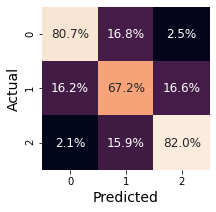

Macro F1 Scores: 
 Training: 0.877 
 Testing: 0.750




In [21]:
y_train_pred, y_test_pred, f1_train, f1_test =\
models.evaluate_pipeline(X_train = X_train_dtm,
                         y_train = y_train,
                         X_test = X_test_dtm,
                         y_test = y_test,
                         pipeline = model)

print("Macro F1 Scores: \n Training: {0:.3f} \n Testing: {1:.3f}\n\n".format(f1_train, f1_test))